# Crimes prediction in Mexico City 

## Data Tranformation


Using data from the General Prosecutor of Justice of Mexico City, and other sources, we create a DataFrame that it was used to predict crimes in Mexico City. 

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import os

import pickle
import glob

from dateutil.relativedelta import relativedelta
import datetime
import ephem ## For lunar phases

import geopandas as gpd

from shapely.geometry import Point
from shapely.geometry import LinearRing
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

from geopandas.tools import sjoin

import matplotlib.pyplot as plt
import plotly.express as px

import matplotlib as mpl
import seaborn as sns
import scikitplot as skplt
from rdrobust import rdrobust,rdbwselect,rdplot

from IPython.display import clear_output

import math

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

In [2]:
## Define your path
PATH = r"D:\francisco_madrigal\Desktop\Tesis\modelo"

def create_path(file_path, path=PATH):
    
    return os.path.join(path, file_path)

### Working with neighborhood's Polygons

In [3]:
## Load Mexico City's neighborhoods (colonias in spanish) DataFrame
# Source: https://datos.cdmx.gob.mx/dataset/coloniascdmx
colonias = gpd.read_file(create_path(r"datos_geo\colonias\coloniascdmx\coloniascdmx.shp"))

## Declare the used coordinate system
colonias.crs = "epsg:4326"

## Print Coordinate Reference System (CRS)
# This is importan to homologue all crs from other georeferenced DataFrames
colonias.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
## Create an unique id per neighborhood that could be used later
colonias['id_colonia'] = colonias.index + 1

## Filter important columns
colonias = colonias[['id_colonia', 'nombre', 'alcaldi', 'cve_col', 'geometry']]

## Rename columns
colonias.columns = ['id_colonia', 'colonia', 'alcaldi', 'cve_col', 'geometry']


In [5]:
## Split multypolygon neighborhoods into Polygons neighborhoods.
to_drop = []

for idx, row in colonias.iterrows():
    
    if type(row['geometry']) == MultiPolygon:
        
        polygons = list(row['geometry'])
        
        colonia = row['colonia']
        
        alcaldi = row['alcaldi']
        
        cve_col = row['cve_col']
        
        id_colonia_drop = row['id_colonia']
        
        to_drop.append(id_colonia_drop)
        
        for count, pol in enumerate(polygons):
            
            new_row = {'id_colonia': colonias.loc[colonias.index[-1], 'id_colonia'] + 1, 
                       'colonia': colonia + "_" + str(count + 1), 
                       'alcaldi': alcaldi, 
                       'cve_col': cve_col + "_" + str(count + 1), 
                       'geometry': pol}
            
            colonias = colonias.append(new_row, ignore_index=True)

## Drop Multipolygon neighborhoods
colonias = colonias[~colonias['id_colonia'].isin(to_drop)]

In [6]:
## Calculate the area in Km2 of each neighborhood polygon
# Need to reconvert CRS of the Geopandas Dataframe to calculate this
# Make a copy of the original DataFrame
colonias_area = colonias.copy(deep=True)

colonias_area.crs = "epsg:4326"

## Use cylindrical equal area (cea) to project
colonias_area = colonias_area.to_crs({'proj':'cea'})

## Estimate area in KM2
colonias_area['area_km2'] = colonias_area['geometry'].area/ 10**6

## Merge area with original neighborhoods DataFrame
colonias = colonias.merge(colonias_area[['id_colonia', 'area_km2']],
                         on='id_colonia',
                         how='left')

del colonias_area

In [7]:
## Save fixed neighborhoods DataFrame for future references

if not os.path.isdir(create_path(r"colonias_fixed")):
    
    os.makedirs(create_path(r"colonias_fixed"))

colonias.to_file(create_path(r"colonias_fixed\colonias_fixed.shp"))

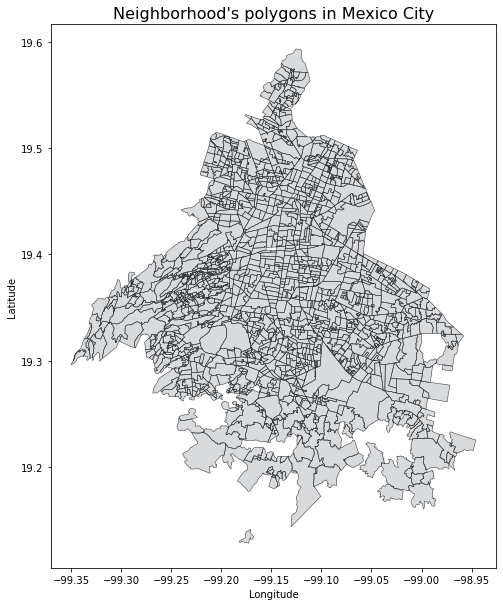

In [8]:
## Draw the map of neighborhoods
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=.5, color="#D8DADC")

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.title(r"Neighborhood's polygons in Mexico City", fontdict={'fontsize': 16})

plt.show()


### Creating the Grid

In [9]:
## Crate a date Grid containing an obvservation every 6 hours
horas = pd.DataFrame(
        {'Hora': pd.date_range('2017-01-01', '2022-03-31', freq='6H', closed='left')})

In [10]:
## Cretate a DataFrame that, for each neighborhoods, contains the date Grid.
grid = pd.DataFrame({})

for colonia, id_colonia in zip(colonias.colonia, colonias.id_colonia):

    df_temp = horas.copy()
    
    df_temp['colonia'] = colonia
    df_temp['id_colonia'] = id_colonia
    
    grid = pd.concat([grid, df_temp])



In [11]:
## Assign a period of day according to the time

# 'early_morning' = 0
# 'morning' = 1
# 'afternoon' = 2 
# 'evening' = 3
grid.loc[grid['Hora'].dt.hour == 0,'day_period'] = 0
grid.loc[grid['Hora'].dt.hour == 6,'day_period'] = 1
grid.loc[grid['Hora'].dt.hour == 12,'day_period'] = 2
grid.loc[grid['Hora'].dt.hour == 18,'day_period'] = 3

## Conver day_period as integer data type
grid['day_period'] = grid['day_period'].astype(int)

if len(grid[grid['day_period'].isna()]) == 0: print('Classification is OK')

Classification is OK


In [12]:
## Create a columns with the day, month and year
grid['day'] = grid['Hora'].dt.day
grid['month'] = grid['Hora'].dt.month
grid['year'] = grid['Hora'].dt.year

In [13]:
## Print the grid
grid.head(5)

Hora               colonia  id_colonia  day_period  day  \
0 2017-01-01 00:00:00  LOMAS DE CHAPULTEPEC           1           0    1   
1 2017-01-01 06:00:00  LOMAS DE CHAPULTEPEC           1           1    1   
2 2017-01-01 12:00:00  LOMAS DE CHAPULTEPEC           1           2    1   
3 2017-01-01 18:00:00  LOMAS DE CHAPULTEPEC           1           3    1   
4 2017-01-02 00:00:00  LOMAS DE CHAPULTEPEC           1           0    2   

   month  year  
0      1  2017  
1      1  2017  
2      1  2017  
3      1  2017  
4      1  2017

### Crimes DataFrame

In [14]:
## Read crimes DataFrame
# Source: https://datos.cdmx.gob.mx/dataset/carpetas-de-investigacion-fgj-de-la-ciudad-de-mexico
crimes = pd.read_csv(create_path(r'carpetas_completa_marzo_2022.csv'), 
                     engine='python', encoding='utf_8')

crimes["fecha_hechos"] = pd.to_datetime(crimes["fecha_hechos"], yearfirst=True, errors='coerce')

print(f"There are {len(crimes)} reported crimes")

There are 1422564 reported crimes


In [15]:
## Filter and drop crimes categorized as Non-criminal and Low Impact Crime
crimes = crimes.query("categoria_delito != 'HECHO NO DELICTIVO' and categoria_delito != 'DELITO DE BAJO IMPACTO'")

## Drop crimes that were registered before 2017
crimes = crimes.query("fecha_hechos >= 2017")

## Finally, filter those crimes that weres reported without georeference (more than 9k :O)
crimes = crimes[(~crimes["latitud"].isna()) & (~crimes["longitud"].isna())]

print(f"There are {len(crimes)} reported crimes in the filtered DataFrame")

There are 196081 reported crimes in the filtered DataFrame


In [16]:
## Change out index for dates
crimes.index = crimes['fecha_hechos']

## Assign periods of the day according with the time of the registered crime
# 'early_morning' = 0
# 'morning' = 1
# 'afternoon' = 2 
# 'evening' = 3
crimes.loc[crimes.between_time(start_time='0:0', 
                               end_time='6:00',
                               include_start=True,
                               include_end=False).index, 'day_period'] = 0

crimes.loc[crimes.between_time(start_time='6:00', 
                               end_time='12:00',
                               include_start=True,
                               include_end=False).index, 'day_period'] = 1


crimes.loc[crimes.between_time(start_time='12:00', 
                               end_time='18:00',
                               include_start=True,
                               include_end=False).index, 'day_period'] = 2

crimes.loc[crimes.between_time(start_time='18:00', 
                               end_time='0:0',
                               include_start=True,
                               include_end=False).index, 'day_period'] = 3


## Conver day_period as integer data type
crimes['day_period'] = crimes['day_period'].astype(int)

if len(crimes[crimes['day_period'].isna()]) == 0: print('Classification is OK')


Classification is OK


In [17]:
## Join reported crimes with the nieghborhood polygon where it were registered.
# Each registered crime in this clean DataFrame has its reported longitude and latitude or point coordinates,
# and each nieghborhood has its polygon.
# If the reported crimes fits within the nieghborhood polygon, then, theres is a join

## Create a point coordinate
crimes['Coordinates'] = list(zip(crimes['longitud'], crimes['latitud']))
crimes['Coordinates'] = crimes['Coordinates'].apply(Point)

## Convert to GeoPandas DataFrame
crimes_geo = gpd.GeoDataFrame(crimes, geometry='Coordinates')

crimes_geo.set_crs(epsg=4326, inplace=True)

## Print Coordinate Reference System (CRS)
crimes_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
## Reset index to follow each crime observation
crimes_geo.reset_index(drop=True, inplace=True)

## Create a column with this index plus one
crimes_geo['indice'] = crimes_geo.index + 1

## Inner join and to drop crimes that are were not reported inside Mexico City
crimes_geo_join = sjoin(crimes_geo, colonias, how="inner")

Additionally, we have a problem with crime point coordinates that fall too close between two polygons. GeoPandas sjoin method duplicates this observations, asssignins the two neighborhoods polygons that are inbetwen the point coordinate.

We can't really do much about it. But if we don't drop the duplicates, we can send bad signals when we train our model. 

There are just a few crimes points that hav this problem (just 17), so, it will no be a big problem.

We show an example of this in the next cell.

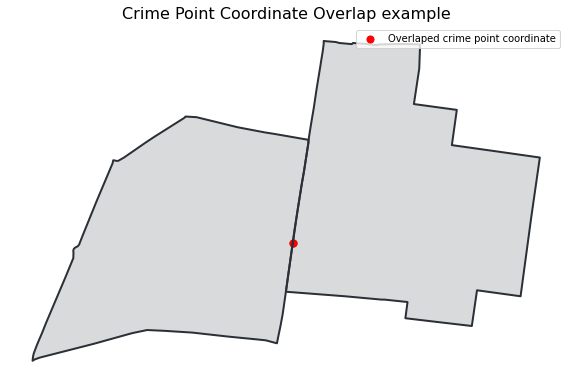

In [19]:
## Overlap crime example
overlap_ex_value = pd.DataFrame(crimes_geo_join['indice'].value_counts()).reset_index().loc[0, "index"]

overlap_ex = crimes_geo_join[crimes_geo_join['indice'] == overlap_ex_value]

colonias_ex_overlap = colonias[colonias['id_colonia'].isin(overlap_ex['id_colonia'].unique())]

## Plot overlap example
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias_ex_overlap.boundary.plot(ax=ax, linewidth=2, color="#2A3036")
colonias_ex_overlap.plot(ax=ax, linewidth=5, color="#D8DADC")
overlap_ex.plot(ax=ax, edgecolor='red', color="red", markersize=50, aspect=1, label='Overlaped crime point coordinate')

ax.set_axis_off()
plt.title('Crime Point Coordinate Overlap example', fontdict={'fontsize': 16})
plt.legend(loc="upper right")
plt.show()

In [20]:
## Drop overlap duplicates. Left the first observation
crimes_geo_join.drop_duplicates(subset='indice', keep='first', inplace=True)

print(f"With the spatial join, the Dataframe is left with {len(crimes_geo_join)} reported crimes.\n\
{(len(crimes_geo)-len(crimes_geo_join))} reported crimes were dropped because they are outside neighborhoods polygons")

With the spatial join, the Dataframe is left with 195490 reported crimes.
591 reported crimes were dropped because they are outside neighborhoods polygons


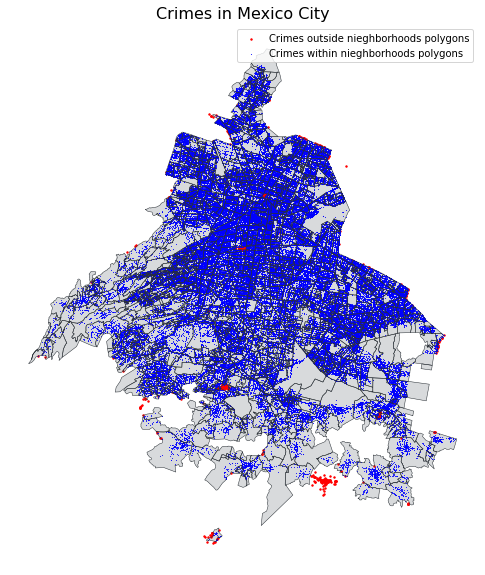

In [21]:
outside_crimes = crimes_geo[~crimes_geo['indice'].isin(crimes_geo_join['indice'].unique())]

## Plot
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=.5, color="#D8DADC")
outside_crimes.plot(ax=ax, color='red', markersize=2, aspect=1,
                   label='Crimes outside nieghborhoods polygons')
crimes_geo_join.plot(ax=ax, color='blue', markersize=.5, aspect=1, lw=0.3, 
                     label='Crimes within nieghborhoods polygons')


ax.set_axis_off()
plt.title('Crimes in Mexico City', fontdict={'fontsize': 16})
plt.legend(loc="upper right")

plt.show()

As we can see in the map, there are some crimes point coordinates that were reported outside any neighborhood polygon (more than 500 coordinate points). Most of them are in the edge of the polygon or within some gaps between polygons. We could try to speculate and assign this crime point to some neighborhood (maybe the closest one). But they represent just the 0.2% of the reported crimes in the DataFrame. It's not important information that can affect our predictions.

### Merging crimes DataFrame with the Grid

In [22]:
## Extract the day, month and year of the reported crime
crimes_geo_join['day'] = crimes_geo_join['fecha_hechos'].dt.day
crimes_geo_join['month'] = crimes_geo_join['fecha_hechos'].dt.month
crimes_geo_join['year'] = crimes_geo_join['fecha_hechos'].dt.year

## Filter just important features
crimes_geo_join = crimes_geo_join.filter(
    items=['day','month','year','day_period','id_colonia','Coordinates','categoria_delito'])

## Create a column of ones that will be represent in the grid the objective feature to predict
crimes_geo_join['crimen'] = 1

In [23]:
## Create categorical variable from the category of the reported crime
crimes_geo_join['categoria_delito'] = crimes_geo_join['categoria_delito'].astype('category')

## Save python dictionary of the crime category and Id
crime_cat_dict = dict(enumerate(crimes_geo_join['categoria_delito'].cat.categories ))

crime_cat_file = open("crime_cat_dict.pkl", "wb")
pickle.dump(crime_cat_dict, crime_cat_file)
crime_cat_file.close()

## Change Series to integer codes
crimes_geo_join['categoria_delito'] = crimes_geo_join['categoria_delito'].cat.codes

In [24]:
## Merge Crimes DataFrame with the Grid

## There are crimes that were reported at the same period of the day in the same neighborhood
# So, to take into account this. 
# In our DataFrame, it could be 2 or more observations with in the same period of time, in the same date and in the same
# neighborhood
matrix_crimes = grid.merge(crimes_geo_join,
                 on=['day', 'month', 'year', 'day_period', 'id_colonia'],
                 how='left')

## Fill nan values with zeros and convert to integer dtype
matrix_crimes['crimen'].fillna(0, inplace=True)
matrix_crimes['crimen'] = matrix_crimes['crimen'].astype(int)

## Days of the week
# Week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6
matrix_crimes['dia_semana'] = matrix_crimes['Hora'].dt.dayofweek

matrix_crimes.reset_index(inplace=True, drop=True)

## Create an unique id from grid
matrix_crimes['indice'] = matrix_crimes.index + 1


In [25]:
del crimes_geo_join, grid, crimes, outside_crimes

### Nearest crime points

Calculating the distance (in Km) between the coordinates of the reported crime and the nearest point of the neighborhood polygon, we want to know if there is an impact on the predicted crimes in the neighborhood X bases on the reported crimes of the near neighborhoods.

In [26]:
## Define a function to  calculate the distance between two points.
# Using Haervesing formula 
# Source: 
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points/4913653#4913653

def haversine(crime_point, hood_point):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    lon_crime = crime_point.x
    lat_crime = crime_point.y

    lon_hood = hood_point.x
    lat_hood = hood_point.y

    # convert decimal degrees to radians 
    lon_crime, lat_crime, lon_hood, lat_hood = map(math.radians, [lon_crime, lat_crime, lon_hood, lat_hood])

    # haversine formula 
    dlon = lon_hood - lon_crime 
    dlat = lat_hood - lat_crime 
    a = math.sin(dlat/2)**2 + math.cos(lat_crime) * math.cos(lat_hood) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

In [27]:
## Filter the matrix with actual crimes
matrix_crimes_actual = matrix_crimes[matrix_crimes['crimen'] == 1].copy(deep=True)

matrix_crimes_actual = matrix_crimes_actual[['id_colonia', 'day_period', 'day', 
                                             'month', 'year', 'Coordinates']]

matrix_crimes_actual.reset_index(drop=True, inplace=True)


In [28]:
## For time saving, save DataFrame file with all the nearest crime points information
# It is just necesary to run it one time

## Create a new folder
if not os.path.isdir(create_path('nearest_neighborhoods')):
    
    os.makedirs(create_path("nearest_neighborhoods"))
    
    
file_exists = os.path.exists((create_path("nearest_neighborhoods\colonias_crimes.csv")))

## Read file if already exists
if file_exists:
    
    colonias_crimes = pd.read_csv(create_path("nearest_neighborhoods\colonias_crimes.csv"))
    
    ## Extract the last date parsed
    last_date_parsed = pd.to_datetime(colonias_crimes[['year', 'month', 'day']]).max()

    ## Filter to save time parsing the new data
    matrix_crimes_actual['date'] = pd.to_datetime(matrix_crimes_actual[['year', 'month', 'day']])

    matrix_crimes_actual = matrix_crimes_actual.query("@last_date_parsed < date")

In [29]:
## Create a function that, for a single crime reported, returns all the neighborhoods within X distance
loop=0

total = len(matrix_crimes_actual)

def near_crimes(point, id_colonia, day_period, day, month, year, colonias_dummy=colonias):
    
    """
    For a single crime reported, returns all the neighborhoods within X distance in Pandas DataFrame
    """
    
    global loop, total

    ## Estimate distance between crime point coordinates and closest point in neighborhoods linear rings
    colonias_dummy['distance'] = [ring.project(point) for ring in colonias_dummy['LinearRing']]

    colonias_dummy['closest_point_coords'] = [ring.interpolate(distance) 
                                              for ring, distance in 
                                              zip(colonias_dummy['LinearRing'], colonias_dummy['distance'])]

    colonias_dummy["distance_Km"] = [haversine(point, ring) for ring in colonias_dummy['closest_point_coords']] 

    ## Filter by a minimum distance
    colonias_dummy = colonias_dummy[colonias_dummy["distance_Km"] <= 0.5]
    
    ## Drop the row that match the neighborhood where the crime were registered
    colonias_dummy = colonias_dummy[colonias_dummy['id_colonia']!=id_colonia]

    colonias_dummy = colonias_dummy[['id_colonia', 'geometry', 'distance_Km', 'closest_point_coords']]
    
    ## Add valuable information for future merge
    colonias_dummy['year'] = year
    colonias_dummy['month'] = month
    colonias_dummy['day'] = day
    colonias_dummy['day_period'] = day_period
    colonias_dummy['coord_crime'] = point
    
    clear_output(wait=True)
    
    loop+=1
    
    print(loop/total)

    return colonias_dummy


In [30]:

## Create the Linear Ring of the polygon of every Neighborhood in the colonias DataFrame
colonias['LinearRing'] = colonias['geometry'].apply(lambda x: LinearRing(x.exterior.coords))


if len(matrix_crimes_actual) > 0:
    
    ## Apply near_crimes function. This function return a DataFrame inside a Pandas Series
    series_crime = matrix_crimes_actual.apply(lambda row: near_crimes(row['Coordinates'], 
                                                                      row['id_colonia'], 
                                                                      row['day_period'], 
                                                                      row['day'], 
                                                                      row['month'], 
                                                                      row['year']), axis=1)

    ## Concat DataFrames clustered in the Pandas Series
    loop=0
    total = len(matrix_crimes_actual.index)

    if not file_exists: colonias_crimes = pd.DataFrame({})

    for x in series_crime.index:

        ## For time
        clear_output(wait=True)
        loop += 1
        print(f"Completado {loop} de {total}")
        print((loop/total)*100)

        colonias_crimes = pd.concat([series_crime[x], colonias_crimes])
        

    colonias_crimes.to_csv(create_path("nearest_neighborhoods\colonias_crimes.csv"),
                           index=False)
    
del matrix_crimes_actual

To show an example of how this algorithm works, we graph a crime point coordinate to show wich neighborhoods are the closest.

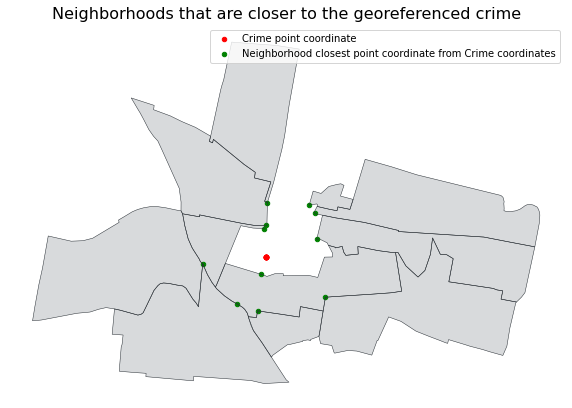

In [31]:
## Example graph
example_graph = colonias_crimes.query("year == 2021 & month == 6 & day == 4 & day_period==0").copy(deep=True)

example_graph.reset_index(drop=True, inplace=True)

example_graph['coord_crime'] = gpd.GeoSeries.from_wkt(example_graph['coord_crime'])
example_graph['geometry'] = gpd.GeoSeries.from_wkt(example_graph['geometry'])
example_graph['closest_point_coords'] = gpd.GeoSeries.from_wkt(example_graph['closest_point_coords'])

# Choose just one crime reported
random_example = example_graph.loc[0,'coord_crime']

example_graph = example_graph[example_graph['coord_crime'] == random_example]

## Example: how nearest points works
crime_points = gpd.GeoDataFrame(example_graph, geometry='coord_crime')

hood_points = gpd.GeoDataFrame(example_graph, geometry='geometry')

close_hood_points = gpd.GeoDataFrame(example_graph, geometry='closest_point_coords')

fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

hood_points.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
hood_points.plot(ax=ax, linewidth=.5, color="#D8DADC")

crime_points.plot(ax=ax, color='red', markersize=20, aspect=1, 
                  label='Crime point coordinate')

close_hood_points.plot(ax=ax, color='green', markersize=20, aspect=1, 
                       label='Neighborhood closest point coordinate from Crime coordinates')

ax.set_axis_off()

plt.legend(loc="upper right")

plt.title('Neighborhoods that are closer to the georeferenced crime', 
          fontdict={'fontsize': 16})

plt.show()

In this graph we can see a reported crime point coordinates (red point) and the closest point of the nearby neighborhoods polygons (green points).

In [32]:
del example_graph, crime_points, hood_points, close_hood_points

In [33]:
## Group matrix by date and then count the number of nearby crimes in the last 14 days.
gped_matrix_near = matrix_crimes.groupby(['day', 'month', 'year', 'id_colonia'])[['crimen']].sum().reset_index()

## Sort by date and neighborhood
gped_matrix_near.sort_values(by=['year', 'month', 'day', 'id_colonia'],
                             inplace=True)

In [34]:
## Count the number of nearby crimes in the last 14 days

## Loop over the maximum distances (meters), and then, over the neighborhoods to count the crimes
for min_dist in [.5]: #A list to estimate with more measures (in Km)
    
    ## Filter database with minimun distance
    df = colonias_crimes.query("distance_Km <= @min_dist").copy(deep=True)
    
    
    # Create a column with unitary values
    df['near_crimes' + "_" + str(int(min_dist*1000)) + "mts"] = 1

    # Group by date
    df_agg = df.groupby(['id_colonia', 'year', 'month', 'day'])\
    ['near_crimes' + "_" + str(int(min_dist*1000)) + "mts"].sum().reset_index()
    
    ## Sort values by date
    df_agg.sort_values(by=['year', 'month', 'day', 'id_colonia'],
                       inplace=True)
    
    
    ## Merge with the grouped matrix. This will assure that the date grid is complete and there is no missing days
    gped_matrix_near = gped_matrix_near.merge(df_agg,
                                              how='left',
                                              on=['id_colonia', 'year', 'month', 'day'])
    
    ## Fill Nan values with zero
    gped_matrix_near['near_crimes' + "_" + str(int(min_dist*1000)) + "mts"].fillna(0, inplace=True)
    
    ## Cum sum of the crimes by neighborhood
    gped_matrix_near['cumsum_crime' + "_" + str(int(min_dist*1000)) + "mts"] = \
    gped_matrix_near.groupby(['id_colonia'])['near_crimes' + "_" + str(int(min_dist*1000)) + "mts"].cumsum()
    

    
    loop = 0

    ## Looking for how many crimes were in the last 14 days (first day not inclusive)
    for nhood in gped_matrix_near['id_colonia'].unique():

        ## For time
        clear_output(wait=True)
        loop += 1
        print((loop/len(gped_matrix_near['id_colonia'].unique()))*100)


        gped_matrix_near.loc[(gped_matrix_near['id_colonia']==nhood), 
                             "past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"] =\
        gped_matrix_near.loc[(gped_matrix_near['id_colonia']==nhood), 
                             'cumsum_crime' + "_" + str(int(min_dist*1000)) + "mts"].diff(15)

    
    ## Fill Nan values with zero
    gped_matrix_near["past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"].fillna(0, inplace=True)
    
    
    

    ## Sustract with the number of crimes that happened in the same day.
    # We are only interested in the past crimes.
    gped_matrix_near["past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"] = \
    gped_matrix_near["past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"] - \
    gped_matrix_near['near_crimes' + "_" + str(int(min_dist*1000)) + "mts"]
    
    matrix_crimes = matrix_crimes.merge(gped_matrix_near[['day', 'month', 'year', 'id_colonia', 
                                                          "past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"]],
                                   how='left',
                                   on=['day', 'month', 'year', 'id_colonia'])

    matrix_crimes["past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"] = \
    matrix_crimes["past_near_crimes" + "_" + str(int(min_dist*1000)) + "mts"].astype(int)
    

100.0


In [35]:
del df, df_agg, gped_matrix_near, colonias_crimes

### Pay day

15th and last day of the month are generally paydays in Mexico.

In [36]:
## Include all the days that are the end of the month
matrix_crimes['pay_day'] = matrix_crimes['Hora'].dt.is_month_end.astype(int)

## And then, the 15th of the month
matrix_crimes.loc[matrix_crimes['day'].isin([15]), 'pay_day'] = 1

### Important dates in Mexico

Some dates are so important in Mexico and can affect crime. Use a dummy to take into account these days.

Some of these days are mandatory holidays (not working days) and are estimated according to article 74 of the Federal labor law.

In [37]:
## Create a DataFrame with the important days that have not complexity
important_dates = pd.DataFrame({'name': ['christmas', 'christmas_eve', 'last_day_year', 
                                         'new_year', 'three_kings', 'day_of_dead', 'independence_day', 
                                         'workers_day'],
                                'day': [25, 24, 31, 1, 6, 2, 16, 1],
                                'month': [12, 12, 12, 1, 1, 11, 9, 5]})

## Iterate over the important dates DataFrame and create a dummmy for every important date
for name_, day_, month_ in zip(important_dates['name'],
                               important_dates['day'],
                               important_dates['month']):
    
    dates_h = ((matrix_crimes['day'] == day_) & (matrix_crimes['month'] == month_))
    
    matrix_crimes.loc[dates_h, name_] = 1
    
    matrix_crimes[name_].fillna(0, inplace=True)
    
    matrix_crimes[name_] = matrix_crimes[name_].astype(int)

In [38]:
## There are more important dates that, due to their complexity, we are going to create the dummy manually

## The first Monday of February in commemoration of February 5 (constitution day)
constitution_day = pd.date_range('2017-01-01',pd.to_datetime("today"),freq='WOM-1MON')
constitution_day = constitution_day[constitution_day.month == 2]

dates_h1 = matrix_crimes['Hora'].isin(np.array(constitution_day).astype('datetime64[ns]')).copy() 
matrix_crimes.loc[dates_h1, 'constitution_day'] = 1
matrix_crimes['constitution_day'].fillna(0, inplace=True)
matrix_crimes['constitution_day'] = matrix_crimes['constitution_day'].astype(int)

## The third Monday of March in commemoration of March 21 (Benito Juarez anniversary)
benito_ann_day = pd.date_range('2017-01-01',pd.to_datetime("today"),freq='WOM-3MON')
benito_ann_day = benito_ann_day[benito_ann_day.month == 3]

dates_h2 = matrix_crimes['Hora'].isin(np.array(benito_ann_day).astype('datetime64[ns]')).copy() 
matrix_crimes.loc[dates_h2, 'benito_ann_day'] = 1
matrix_crimes['benito_ann_day'].fillna(0, inplace=True)
matrix_crimes['benito_ann_day'] = matrix_crimes['benito_ann_day'].astype(int)

## The third Monday of November in commemoration of November 20
revolution_day = pd.date_range('2017-01-01',pd.to_datetime("today"),freq='WOM-3MON')
revolution_day = revolution_day[revolution_day.month == 11]

dates_h3 = matrix_crimes['Hora'].isin(np.array(revolution_day).astype('datetime64[ns]')).copy() 
matrix_crimes.loc[dates_h3, 'revolution_day'] = 1
matrix_crimes['revolution_day'].fillna(0, inplace=True)
matrix_crimes['revolution_day'] = matrix_crimes['revolution_day'].astype(int)

In [39]:
## Holy Week

## Create an empty list
holywd_list = []

for year in range(2017, pd.to_datetime("today").year+1):
    
    ## The end of Holy week is estimated by the next sunday of
    # the first full moon after march 21 (not inclusive)
    date_moon= ephem.Date(pd.to_datetime(f"22-3-{year}"))

    ## Estimate the next full moon
    full_moon = ephem.next_full_moon(date_moon)

    ## Next sunday after the full moon 
    end_holyw = (full_moon.datetime() + pd.offsets.Week(weekday=6)).date()

    start_holyw = (end_holyw - pd.offsets.Week(weekday=6)).date()

    holyw_dates = np.array(pd.date_range(start_holyw,end_holyw))
    
    holywd_list.extend(holyw_dates)
    
## Convert to np array
holywd_list = np.array(holywd_list).astype('datetime64[ns]')

## Crate a column of ones with holy week dates
dates_hw = matrix_crimes['Hora'].isin(holywd_list).copy()
matrix_crimes.loc[dates_hw, 'holy_week'] = 1
matrix_crimes['holy_week'].fillna(0, inplace=True)
matrix_crimes['holy_week'] = matrix_crimes['holy_week'].astype(int)

In [40]:
## Create a columns with no labor days 
# (it is an aggregate from all the mandataory holidays that and are within weekdays
# and saturdays and sundays)

# Crate a column of zeros
matrix_crimes['no_labor_day'] = 0

## Fill with ones all sundays and saturdays
#dates_nl = matrix_crimes['dia_semana'].isin([5,6]).copy() 
#matrix_crimes.loc[dates_nl, 'no_labor_day'] = 1

## Fill with all mandatory no labor days in Mexico
matrix_crimes['no_labor_day'] = (matrix_crimes['no_labor_day'] + 
                                 matrix_crimes['constitution_day'] + 
                                 matrix_crimes['benito_ann_day'] + 
                                 matrix_crimes['revolution_day'] + 
                                 matrix_crimes['christmas'] + 
                                 matrix_crimes['new_year'] + 
                                 matrix_crimes['independence_day'] + 
                                 matrix_crimes['workers_day'])
                                 
## Make grater than 1 values to 1
matrix_crimes['no_labor_day'] = [1 if x >= 1 else 0 for x in matrix_crimes['no_labor_day']]

### Past crimes

In [41]:
## Crimes in past days

## We look up for crimes in past days in the same neighborhood
gped_matrix = matrix_crimes.groupby(['day', 'month', 'year', 'id_colonia'])[['crimen']].sum().reset_index()

gped_matrix.sort_values(by=['year', 'month', 'day', 'id_colonia'],
                        inplace=True)

gped_matrix['cumsum_crime'] = gped_matrix.groupby(['id_colonia'])['crimen'].cumsum()


loop = 0

## Look how many crimes where in the last 14 days (first day not inclusive)
for nhood in matrix_crimes['id_colonia'].unique():
    
    ## For time
    clear_output(wait=True)
    loop += 1
    print((loop/len(matrix_crimes['id_colonia'].unique()))*100)


    gped_matrix.loc[(gped_matrix['id_colonia']==nhood), 'past_crimes'] = gped_matrix.loc[

        (gped_matrix['id_colonia']==nhood), 'cumsum_crime'].diff(15)
    

gped_matrix['past_crimes'].fillna(0, inplace=True)

gped_matrix['past_crimes'] = gped_matrix['past_crimes'] - gped_matrix['crimen']

matrix_crimes = matrix_crimes.merge(gped_matrix[['day', 'month', 'year', 'id_colonia', 'past_crimes']],
                                   how='left',
                                   on=['day', 'month', 'year', 'id_colonia'])




100.0


In [42]:
## We exclude observations of the first 2 weeks of 2017, because we dont have information of the past crimes
date_cut = matrix_crimes.loc[0, "Hora"] + np.timedelta64(15,'D')

matrix_crimes = matrix_crimes.query('Hora >= @date_cut').copy()

In [43]:
del gped_matrix

### Subway and bus stations

#### Subway (Metro)

In [44]:
## Count the number of metro stations that are within each neighborhood

## Read the shapefile
# Source: https://datos.cdmx.gob.mx/dataset/lineas-y-estaciones-del-metro
#metro = gpd.read_file(create_path(r"datos_geo\metro\estaciones_del_metro\estaciones_del_metro.shp")) 
metro = gpd.read_file(create_path(r"datos_geo\metro\stcmetro_shp\STC_Metro_estaciones_utm14n.shp"))

## Print Coordinate Reference System (CRS)
metro.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [45]:
## Filter the columns that are useless
metro = metro[['NOMBRE', 'TIPO', 'LINEA', 'geometry']]

## Spatial join the point coordinate of the metro stations with neighborhoods polygons.
col_metro = sjoin(metro, colonias, how="inner")

## Group by neighborhood
col_metro = col_metro.groupby('id_colonia').size().reset_index()

## Rename columns
col_metro.columns = ['id_colonia', 'metro']

## Merge with original neighborhoods DataFrane
colonias = colonias.merge(col_metro,
                          how='left',
                          on='id_colonia')

colonias['metro'].fillna(0, inplace=True)
colonias['metro'] = colonias['metro'].astype(int)

Overlap it’s not relevant with subway and bus stations. If there is a station that is counted in two neighborhoods it could be a good signal for the model to consider that in the two neighborhoods are this kind of stations.

#### Metrobus

In [46]:
## Read metrobus's shapefile
# Source: https://datos.cdmx.gob.mx/dataset/geolocalizacion-metrobus
metrobus = gpd.read_file(create_path(r"datos_geo\metro\mb_shp\Metrobus_estaciones_utm14n.shp"))

metrobus.crs = "epsg:32614"

## This shapefile need to be converted to crs: epsg:4326
metrobus.to_crs(epsg=4326, inplace=True)

## Print Coordinate Reference System (CRS)
metrobus.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
## Filter the columns that are useless
metrobus = metrobus[['NOMBRE', 'LINEA', 'geometry']]

## Spatial join the point coordinate of the metrobus stations with neighborhoods polygons.
col_metrobus = sjoin(metrobus, colonias, how="inner")

## Group by neighborhood
col_metrobus = col_metrobus.groupby('id_colonia').size().reset_index()

## Rename columns
col_metrobus.columns = ['id_colonia', 'metrobus']

## Merge with original neighborhoods DataFrane
colonias = colonias.merge(col_metrobus,
                          how='left',
                          on='id_colonia')

colonias['metrobus'].fillna(0, inplace=True)
colonias['metrobus'] = colonias['metrobus'].astype(int)

#### RTP bus

In [48]:
## Read the shapefile
# I think they erase the stops, but this is the source from the routes
# Source: https://datos.cdmx.gob.mx/dataset/paradas-de-rtp
rtp = gpd.read_file(create_path(r"datos_geo\metro\paradas_de_rtp\paradas_de_rtp.shp"))

## Print Coordinate Reference System (CRS)
rtp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
## Filter the columns that are useless
rtp = rtp[['stop_nm', 'geometry']]

## Spatial join the point coordinate of the RTP stations with neighborhoods polygons.
col_rtp = sjoin(rtp, colonias, how="inner")

## Group by neighborhood
col_rtp = col_rtp.groupby('id_colonia').size().reset_index()

## Rename columns
col_rtp.columns = ['id_colonia', 'rtp']

## Merge with original neighborhoods DataFrane
colonias = colonias.merge(col_rtp,
                          how='left',
                          on='id_colonia')

colonias['rtp'].fillna(0, inplace=True)
colonias['rtp'] = colonias['rtp'].astype(int)

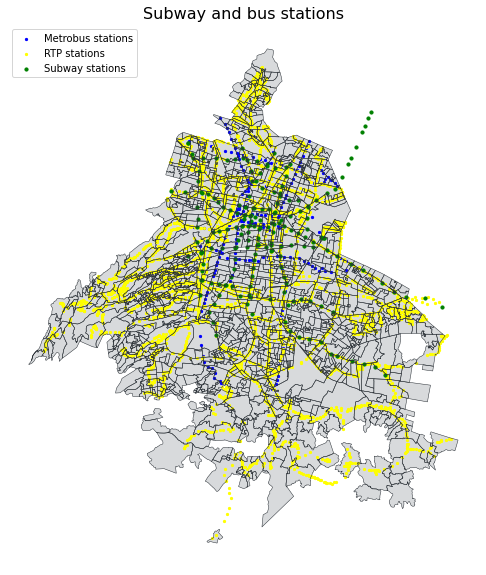

In [50]:
## Plot stations
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=.5, color="#D8DADC")

metrobus.plot(ax=ax, color='blue', markersize=5, aspect=1, label='Metrobus stations')
rtp.plot(ax=ax, color='yellow', markersize=5, aspect=1, label='RTP stations')
metro.plot(ax=ax, color='green', markersize=10, aspect=1, label='Subway stations')

ax.set_axis_off()
plt.legend(loc="upper left")
plt.title('Subway and bus stations', fontdict={'fontsize': 16})

plt.show()

In [51]:
del (col_rtp, 
     rtp, 
     metrobus, 
     col_metrobus, 
     col_metro, 
     metro)

### Economic Units

Using information from the economic census (INEGI), count the number of economic units by neighborhood. 

We are interested in few kind of economic business like banks, restaurants, mini and supermarkets and corporate offices.

Source: https://www.inegi.org.mx/app/descarga/

In [52]:
## Read the csv file for the number of business
denue = pd.read_csv(create_path(r"denue\denue_inegi_09_.csv"), encoding='latin-1', low_memory=False)

## We filter the useless columns
denue = denue[['codigo_act', 'nombre_act', 'per_ocu', 'longitud', 'latitud']]

## We create a columns to classify SCIAN subsectors
denue['subsector'] = denue['codigo_act'].astype(str).str.slice(start=0, stop=3)

## We apply POINT GeoPandas's function
denue['Coordinates'] = list(zip(denue['longitud'], denue['latitud']))
denue['Coordinates'] = denue['Coordinates'].apply(Point)

## We convert our metrobus DataFrame into a GeoPandas DataFrame
denue = gpd.GeoDataFrame(denue, geometry='Coordinates')

## This file need to be converted to crs: epsg:4326
denue.set_crs(4326, inplace=True)

## Print Coordinate Reference System (CRS)
denue.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
## Filter just the kind (subsector) of economic units that are relevant
# 461, 462 mini and supermarkets
# 551 corporate offices
# 722 restaurants
# 522 banks
subsectores = ['461', '462', '551', '722', '522']

denue = denue[denue['subsector'].isin(subsectores)]

In [54]:
## Spatial join the point coordinates of the economic units with neighborhood's polygon
col_denue = sjoin(denue, colonias, how="inner")

## Save a copy just for the fun of graphs
col_denue_graph = col_denue.copy(deep=True)

## Group by neighborhood and subsector
col_denue = col_denue.groupby(['id_colonia', 'subsector']).size().reset_index()

col_denue.columns = ['id_colonia', 'subsector', 'num_esta']

## Rename the subsectors (kind of economic unit)
col_denue['subsector'] = [f"num_esta_sub_{str(sub)}" for sub in col_denue['subsector']]

## Reshape the DataFrame
col_denue = col_denue.pivot_table(values='num_esta', index='id_colonia', columns='subsector').reset_index()

## Fill Nan values or neighborhoods without that kind of economic unit
col_denue.fillna(0, inplace=True)

## Convert dtype ad integer
for col in col_denue.columns: col_denue[col] = col_denue[col].astype(int)


## Rename columns
col_denue.rename(columns={'num_esta_sub_551': "corporate_offices",
                          'num_esta_sub_722': "restaurants",
                          'num_esta_sub_522': "banks",
                          'num_esta_sub_461': 'supers_minisupers',
                          'num_esta_sub_462': 'department_stores'}, inplace=True)

## Merge with neighborhoods DataFrame
colonias = colonias.merge(col_denue,
                          how='left',
                          on='id_colonia')

colonias.fillna(0, inplace=True)

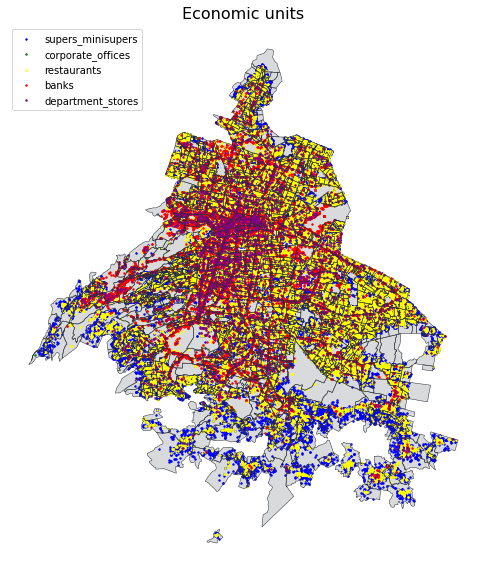

In [55]:
## Plot economic units
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=2, color="#D8DADC")

col_denue_graph[col_denue_graph['subsector'] == '461'].\
plot(ax=ax, color='blue', markersize=2, aspect=1, label='supers_minisupers')

col_denue_graph[col_denue_graph['subsector'] == '551'].\
plot(ax=ax, color='green', markersize=2, aspect=1, label='corporate_offices')

col_denue_graph[col_denue_graph['subsector'] == '722'].\
plot(ax=ax, color='yellow', markersize=2, aspect=1, label='restaurants')

col_denue_graph[col_denue_graph['subsector'] == '522'].\
plot(ax=ax, color='red', markersize=2, aspect=1, label='banks')

col_denue_graph[col_denue_graph['subsector'] == '462'].\
plot(ax=ax, color='purple', markersize=2, aspect=1, label='department_stores')

ax.set_axis_off()
plt.legend(loc="upper left")
plt.title('Economic units', fontdict={'fontsize': 16})

plt.show()

In [56]:
del col_denue, denue, col_denue_graph

### Population census

Using the Population Census 2020 (INEGI), we extract infromation that could be useful for our model: population, and education, and access to medical services as proxy of poverty.

Multiple sources: 

Open data: https://www.inegi.org.mx/programas/ccpv/2020/default.html#Datos_abiertos

Geostatistical Framework: https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469

SCITEL: https://www.inegi.org.mx/app/scitel/Default?ev=10


We use street blocks (or manzanas in spanish) to spatially join with neighborhoods. Cannot use AGEB (Basic Geostatistical Area), because the neighborhood does not completly are within AGEBs. There are some AGEB's polygon that overlaps with one or more neighborhood so we need a smaller and desintegrated measure. In order to use street blocks, we need to extract the centroid of each block's polygon. We will match each street block with its neighborhood according with it's centroid.

In [57]:
## Read street blocks (AGEB) shape file
ageb = gpd.read_file(create_path(r"datos_geo\geo_cdmx\conjunto_de_datos\09m.shp"))

## Estimate it's centroid
ageb['geometry'] = ageb['geometry'].centroid

## Convert to correct CRS
ageb.set_crs(4326, allow_override=True)

ageb.to_crs('epsg:4326', inplace=True)

## Original CRS form this shapefile was EPSG:6365 or Mexico ITRF2008
ageb.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

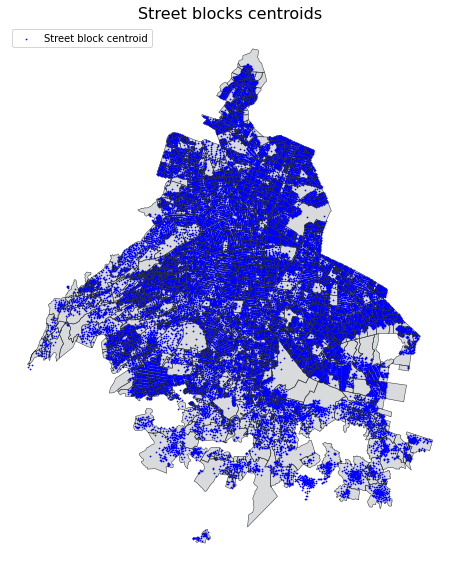

In [58]:
## Plot street blocks centroids to show that perfect fits the map of Mexico City's neighborhoods
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=2, color="#D8DADC")
ageb.plot(ax=ax, markersize=.5, color='blue', label='Street block centroid')

ax.set_axis_off()
plt.legend(loc="upper left")
plt.title('Street blocks centroids', fontdict={'fontsize': 16})

plt.show()

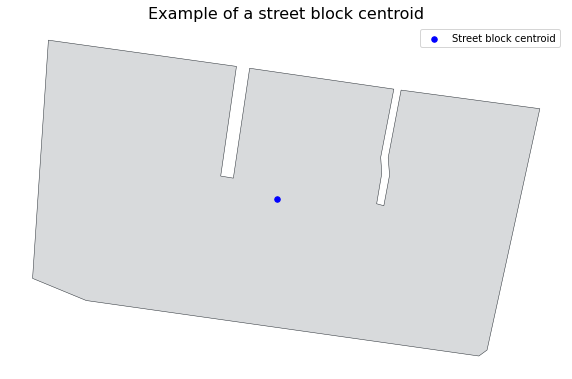

In [59]:
## Show an example of how centroid works
ageb_shape = gpd.read_file(create_path(r"datos_geo\geo_cdmx\conjunto_de_datos\09m.shp"))

ageb_shape.set_crs(4326, allow_override=True)

ageb_shape.to_crs('epsg:4326', inplace=True)


fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

block = ageb_shape[(ageb_shape['CVE_MUN'] == "014") & 
                   (ageb_shape['CVE_MZA'] == "009") & 
                   (ageb_shape['CVE_AGEB'] == "0670")]

center = ageb[(ageb['CVE_MUN'] == "014") & 
              (ageb['CVE_MZA'] == "009") & 
              (ageb_shape['CVE_AGEB'] == "0670")]


block.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
block.plot(ax=ax, linewidth=2, color="#D8DADC")

center.plot(ax=ax, markersize=30, color='blue', label='Street block centroid')

plt.title('Example of a street block centroid', fontdict={'fontsize': 16})
plt.legend(loc="upper right")
ax.set_axis_off()

plt.show()


In [60]:
del ageb_shape

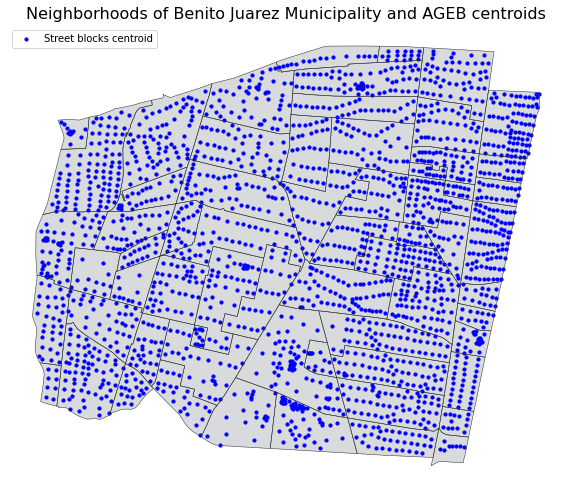

In [61]:
## Show an other example of a municipality (Alcaldia) and all street block centroids that are within
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias[colonias["alcaldi"] == 'BENITO JUAREZ'].boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias[colonias["alcaldi"] == 'BENITO JUAREZ'].plot(ax=ax, linewidth=2, color="#D8DADC")

ageb[ageb['CVE_MUN'] == "014"].plot(ax=ax, markersize=10, color='blue', label='Street blocks centroid')

plt.title('Neighborhoods of Benito Juarez Municipality and AGEB centroids', fontdict={'fontsize': 16})
plt.legend(loc="upper left")
ax.set_axis_off()

plt.show()


In [62]:
## Read the Census Population DataFrame
censo = pd.read_csv(
    create_path(r'datos_geo\ageb_mza_urbana_09_cpv2020\conjunto_de_datos\conjunto_de_datos_ageb_urbana_09_cpv2020.csv'),
    na_values = ["*", 'N/D'])

totals = ['Total de la entidad', 'Total del municipio', 'Total de la localidad urbana', 'Total AGEB urbana']

## Filter the totals
censo = censo[~censo['NOM_LOC'].isin(totals)]

## To be able to merge with ageb DataFrame
censo['MZA'] = censo['MZA'].astype(str).apply(lambda x: x.zfill(3))
censo['LOC'] = censo['LOC'].astype(str).apply(lambda x: x.zfill(4))
censo['MUN'] = censo['MUN'].astype(str).apply(lambda x: x.zfill(3))

# POBTOT: Street block's total population
# GRAPROES: Average grade of schooling
# PSINDER: Population without affiliation to health services
# TOTHOG: Total households

columns_of_interest = ['MUN', 'LOC', 'AGEB','MZA','POBTOT', 'GRAPROES', 'PSINDER', 'TOTHOG']
                       
censo = censo[columns_of_interest]

censo.rename(columns = {'MUN': 'CVE_MUN',
                        'LOC': 'CVE_LOC',
                        'AGEB': 'CVE_AGEB',
                        'MZA': 'CVE_MZA'},
            inplace=True)

In [63]:
## Merge census with street block georeference
censo = censo.merge(ageb,
                    how='left',
                    on=['CVE_MUN', 'CVE_LOC','CVE_AGEB', 'CVE_MZA'])

## Drop Nan values. There are some street block that could not merge with census DataFrame (just 6)
censo = censo[~censo['geometry'].isna()]

## Convert Pandas DataFrame as GeoPandas Dataframe
censo = gpd.GeoDataFrame(censo, geometry='geometry')

In [64]:
## Create and column index to use later
censo['indice_ej'] = censo.index

## Make a copy of roiginal Censo DataFrame
censo_copy = censo.copy(deep=True)

## Spatial join street blocks and neighborhoods DataFrame 
censo = sjoin(censo, colonias[['id_colonia', 'geometry']], how="inner")

As happended before with the crimes point coordinates, there are some street blocks point coordinates that are not within neighborhoods polygons. This observations will be dropped.

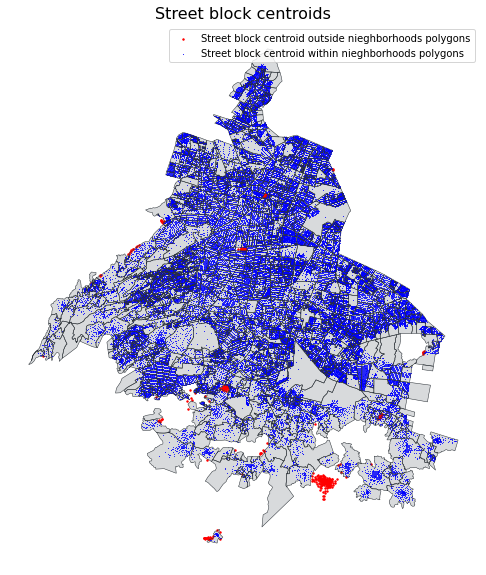

In [65]:
## Graph ourside and inside street block centroids as an example
censo_copy = censo_copy[~censo_copy['indice_ej'].isin(censo['indice_ej'].unique())]

## Plot
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=.5, color="#D8DADC")

censo_copy.plot(ax=ax, color='red', markersize=2, aspect=1,
                label='Street block centroid outside nieghborhoods polygons')

censo.plot(ax=ax, color='blue', markersize=.5, aspect=1, lw=0.3, 
           label='Street block centroid within nieghborhoods polygons')


ax.set_axis_off()
plt.title('Street block centroids', fontdict={'fontsize': 16})
plt.legend(loc="upper right")

plt.show()

In [66]:
## Tranform GRAPROES to make a weighted avarage per neighborhood.
# Estimate the total population per neighborhood
censo['pop_colonia'] = censo.groupby('id_colonia')['POBTOT'].transform('sum')

## Estimate the relative population per neighborhood
censo['rel_pop_colonia'] = censo['POBTOT'] / censo['pop_colonia']

## Estimate the weighted avarage
censo['g_edu'] = censo['GRAPROES'] * censo['rel_pop_colonia']

## Group by neighborhood
censo = censo.groupby(['id_colonia'])[['POBTOT', 'TOTHOG', 'PSINDER', 'g_edu']].sum().reset_index()

## Estimate the percentage of population without health services by neighborhood
censo['no_healt_s'] = censo['PSINDER'] / censo['POBTOT']

censo.drop(columns=['PSINDER'], axis=1, inplace=True)

In [67]:
## Merge census information with neighborhoods DataFrame
colonias = colonias.merge(censo,
                          how='left',
                          on='id_colonia')

## There are 4 neighborhoods without census information. 
# Fill it with zeros. Assuming these neighborhoods have no population living there.
colonias.fillna(0, inplace=True)


In [68]:
## Do some transformations:
# Estimate population and housholds density (per KM2)
colonias['pop_per_km2'] = colonias['POBTOT'] / colonias['area_km2']
colonias['house_per_km2'] = colonias['TOTHOG'] / colonias['area_km2']

## Drop columns with totals
colonias.drop(columns=['TOTHOG', 'POBTOT'], axis=1, inplace=True)

In [69]:
del censo, ageb

### Weather

Using the Global Surface Summary of the Day from National Centers for Environmental Information (NCEI), I estimated the mean daily temperature of Mexico City. 

I used the two stations that have most of the daily weather information: 

* 76679399999 - LICENCIADO BENITO JUAREZ INTERNATIONAL
* 76680099999 - MEXICO CENTRAL D.F.

Source: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516

TEMP - Mean temperature (.1 Fahrenheit) <br>
DEWP - Mean dew point (.1 Fahrenheit) <br>
SLP - Mean sea level pressure (.1 mb) <br>
STP - Mean station pressure (.1 mb) <br>
VISIB - Mean visibility (.1 miles) <br>
WDSP – Mean wind speed (.1 knots) <br>
MXSPD - Maximum sustained wind speed (.1 knots) <br>
GUST - Maximum wind gust (.1 knots) <br>
MAX - Maximum temperature (.1 Fahrenheit) <br>
MIN - Minimum temperature (.1 Fahrenheit) <br>
PRCP - Precipitation amount (.01 inches) <br>
SNDP - Snow depth (.1 inches) <br>

In [70]:
## Read weather DataFrame
clima = pd.read_csv(create_path(r"clima\weather.csv"), 
                    parse_dates =['DATE'])

## Filter stations
clima = clima.query('STATION == 76679399999 | STATION == 76680099999')

## Group and estimate the daily mean temperature and other interest variables
clima = clima.groupby([clima['DATE']])[['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'PRCP']].mean()

## Make sure don't miss any day in the times series.
# There are 3 missing days.
# Interpolate linearly
clima = clima.resample('1D').interpolate(method='linear').reset_index()

## Filter the features that are important to make crime predictions
clima = clima.filter(items=['DATE', 'TEMP', 'PRCP'])

## Create temporal feature to make more easy to merge
matrix_crimes['DATE'] = pd.to_datetime(matrix_crimes['Hora'].dt.date)

## Merge the DataFrames
matrix_crimes = matrix_crimes.merge(clima,
                                    how='left',
                                    on='DATE')

del clima

### Air pollution

Daily mean of air pollutants from the Environmental Agency of Mexico City.

Air pollutants:

* CO - Carbon monoxide
* NO - Nitric oxide
* NO2	- Nitrogen dioxide
* NOx	- Nitrogen oxides
* O3 - Ozone
* PM10 - Particles smaller than 10 micrometers
* PM2.5 - Particles smaller than 2.5 micrometers
* PMco - Coarse particles


Source: http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmM=%27

In [71]:
## Create a list of the pollutants
pollutants_list = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM25', 'PMCO', 'SO2']

## The Pollutants DataFrame contains information from stations that are not in Mexico City,
# So, we need to make a list of the stations that are in Mexico City neighborhoods
stations = ['AJM', 'ARA','AZC','BJU','CAM','CCA','CES','CFE','COR','COY','CUA','CUI','DIC','EAJ','EDL',
            'FAN','GAM','HAN','HGM','IBM','IMP','IZT','LAA','LAG','LOM','LVI','MCM','MER','MGH','MIN',
            'MPA','PED','PLA','POT','SFE','SHA','SJA','SUR','TAC','TAH','TAX','TEC','TPN', 'UAX','UIZ','UNM',
            'VAL','XCH','SAC']

## Create Function to iter over pollutants
def iter_pollutant(df_list):
    
    pollutant_df = pd.DataFrame({})
    
    for df in df_list:
    
        pol_df = pd.read_excel(df, parse_dates=['FECHA'])

        pol_df.replace(-99, np.nan, inplace=True)

        stations_match = list(set(stations) & set(pol_df.columns))

        pol_df =  pol_df[['FECHA', 'HORA'] + stations_match]

        pol_df[pollutant] = pol_df[stations_match].mean(axis=1)

        pol_df = pol_df.groupby(['FECHA'])[[pollutant]].mean().reset_index()
        
        pollutant_df = pd.concat([pollutant_df, pol_df])
        
    return pollutant_df


## Create an empty DataFrame of pollutants
pollutants = pd.DataFrame({})

## Iterate over the Pollutants to create a defenitive pollutants DataFrame
for pollutant in pollutants_list:
    
    pollutant_path = r'contaminacion\data\*[0-9]' + pollutant + '.xls'
    
    df_list = glob.glob(create_path('') + pollutant_path)
    
    pollutant_df = iter_pollutant(df_list)
    
    if pollutants.empty:
        
        pollutants = pd.concat([pollutants, pollutant_df])
        
    else:
        
        pollutants = pollutants.merge(pollutant_df,
                                      how='outer',
                                     on='FECHA')
    
    
pollutants.rename(columns = {'FECHA': 'DATE'},
                  inplace=True)

## Filter just the pollutant that are going to be into the model
pollutants = pollutants.filter(items=['DATE', 'CO','O3','PM10'])

## Merge the DataFrames
matrix_crimes = matrix_crimes.merge(pollutants,
                                    how='left',
                                    on='DATE')

del pollutants

matrix_crimes.drop(columns=['DATE'], axis=1, inplace=True)

### Mobility

We use vial accidents information as a proxy of mobility. We show that car accidents are strongly correlated with mobility.

Sources:

Car accidents: https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5

Google mobility: https://www.google.com/covid19/mobility/



In [72]:
## Read car accidents DataFrame
incidentes = pd.read_csv(create_path(r'mobility\incidentes_viales_c5.csv'), 
                         encoding='ISO-8859-1',
                         low_memory=False)

## Data -at October 2021- has some mixed columns.
# It is needed to fix this.
incidentes = incidentes[(incidentes["codigo_cierre"] == 'A') | (incidentes["ano_cierre"] == 'A')]

incidentes.rename(columns={'fecha_creacion':'folio_date'}, inplace=True)

incidentes['folio_date'] = pd.to_datetime(incidentes['folio_date'], errors='coerce')

## Filter accidents after 2017
incidentes = incidentes[incidentes['ano_cierre'] >= 2017]

## Drop observations that does not have georeference information
init_obs = len(incidentes)
incidentes = incidentes[(~incidentes["latitud"].isna()) & (~incidentes["longitud"].isna())]

print(f"There are {init_obs-len(incidentes)} car accidents without georeference. ")

There are 133 car accidents without georeference. 


In [73]:
## Tranform Pandas DataFrame into a GeoPandas DataFrame
incidentes['Coordinates'] = list(zip(incidentes['longitud'].astype(float), incidentes['latitud'].astype(float)))
incidentes['Coordinates'] = incidentes['Coordinates'].apply(Point)

incidentes = gpd.GeoDataFrame(incidentes, geometry='Coordinates')

## Convert to the correct CRS
incidentes.crs = 'epsg:4326'

incidentes.to_crs('epsg:4326', inplace=True)

incidentes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [74]:
## Reset index to follow each accident observation
incidentes.reset_index(drop=True, inplace=True)

## Create a column with this index plus one
incidentes['indice'] = incidentes.index + 1

## Inner join and to drop car accidents that are were not reported inside Mexico City's neighborhoods polygons
incidentes_join = sjoin(incidentes, colonias[['id_colonia', 'colonia', 'alcaldi', 'geometry']], 
                        how="inner")

## As crimes, the are some overlaped accidents that were reported between two neighborhoods.
## Drop overlap duplicates. Left the first observation
incidentes_join.drop_duplicates(subset='indice', keep='first', inplace=True)

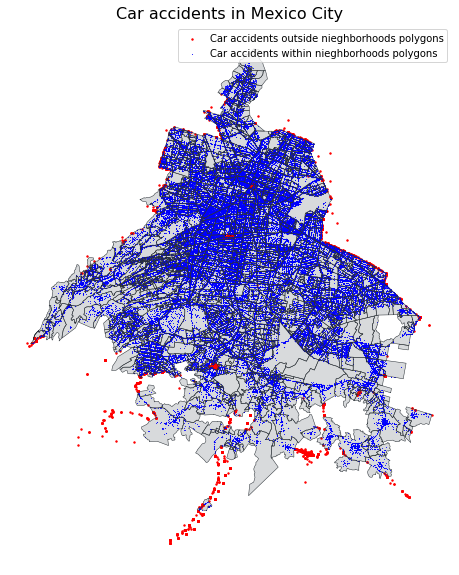

In [75]:
outside_accidents = incidentes[~incidentes['indice'].isin(incidentes_join['indice'].unique())]

## Plot
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

colonias.boundary.plot(ax=ax, linewidth=.5, color="#2A3036")
colonias.plot(ax=ax, linewidth=.5, color="#D8DADC")
outside_accidents.plot(ax=ax, color='red', markersize=2, aspect=1,
                   label='Car accidents outside nieghborhoods polygons')
incidentes_join.plot(ax=ax, color='blue', markersize=.5, aspect=1, lw=0.3, 
                     label='Car accidents within nieghborhoods polygons')


ax.set_axis_off()
plt.title('Car accidents in Mexico City', fontdict={'fontsize': 16})
plt.legend(loc="upper right")

plt.show()

In [76]:
## Group and calculate daily accidents
daily_accidents = incidentes_join.groupby([incidentes_join['folio_date'].dt.date]).size().reset_index()

## Rename columns
daily_accidents.columns = ['folio_date', "accidents"]

daily_accidents["folio_date"] = pd.to_datetime(daily_accidents["folio_date"])

## Copy date to index to resample
daily_accidents.index = daily_accidents["folio_date"]

In [77]:
## Create a column with the day of the week and month
daily_accidents['weekdays'] = daily_accidents['folio_date'].dt.weekday
daily_accidents['month'] = daily_accidents['folio_date'].dt.month

## Estimate the median accidents form de 5 weeks baseline
median_acc = daily_accidents.groupby(['weekdays', 'month']).median().reset_index()


median_acc.columns = ['weekdays', 'month', 'reference_accidents']

In [78]:
## Merge the median baseline per day of the week and month
daily_accidents = daily_accidents.merge(median_acc,
                                       how='left',
                                       on=['weekdays', 'month'])

## Estimate the percentage change of accidents
daily_accidents['change_accidents'] = round(((daily_accidents['accidents'] / 
                                              daily_accidents['reference_accidents']) - 1 )*100, 2)

In [79]:
## Plot it

## Create a moving avarage to smooth the series
daily_accidents['change_accidents_ma'] = daily_accidents['change_accidents'].rolling(60).mean()

##
upper = daily_accidents.query("'2020-03-23' > folio_date")['change_accidents_ma'].max()
lower = daily_accidents.query("'2020-03-23' > folio_date")['change_accidents_ma'].min()


fig = px.line(daily_accidents, x="folio_date", y="change_accidents_ma")
fig.add_hline(y=upper)
fig.add_hline(y=lower)

fig.write_html("movilidad.html")

fig.update_layout(title='Evolution of car accidents',
                   xaxis_title='Date',
                   yaxis_title='% Change')

fig.show()

#### Correlation between Google mobility and car accidents

In [80]:
## Read Google Mobility DataFrame
google_mobility = pd.read_csv(create_path(r"mobility\Global_Mobility_Report.csv"),
                              low_memory=False, parse_dates =['date'])

## Filter just Mexico City data
google_mobility = google_mobility.query("country_region == 'Mexico' & sub_region_1 == 'Mexico City'")

## Filter important fetures
google_mobility = google_mobility[["date", 
                                   "retail_and_recreation_percent_change_from_baseline",
                                   "grocery_and_pharmacy_percent_change_from_baseline",
                                   "parks_percent_change_from_baseline",
                                   "transit_stations_percent_change_from_baseline",
                                   "workplaces_percent_change_from_baseline",
                                   "residential_percent_change_from_baseline"]]

## Rename to be more easy to merge and to read
google_mobility.rename(columns={'date': "folio_date",
                                "retail_and_recreation_percent_change_from_baseline": "retail_and_recreation",
                                "grocery_and_pharmacy_percent_change_from_baseline": "grocery_and_pharmacy",
                                "parks_percent_change_from_baseline": "parks_percent",
                                "transit_stations_percent_change_from_baseline": "transit_stations",
                                "workplaces_percent_change_from_baseline": "workplaces",
                                "residential_percent_change_from_baseline": "residential"}, inplace=True)


In [81]:
## Estimate again the median accidents form de 5 weeks baseline, but agregated to all Mexico City
# To be comparable with Google Mobility

## Based on Google Mobility methodology, we use the median value as the baseline 
# for the corresponding day of the week during the five weeks Jan 3–Feb 6, 2020.
# Google Mobility methodology: https://www.google.com/covid19/mobility/data_documentation.html?hl=en

## Group and calculate aggregated daily accidents
daily_accidents_agg = incidentes_join.groupby([incidentes_join['folio_date'].dt.date]).size().reset_index()

## Rename columns
daily_accidents_agg.columns = ['folio_date', "accidents"]

daily_accidents_agg["folio_date"] = pd.to_datetime(daily_accidents_agg["folio_date"])

## Copy date to index to resample
daily_accidents_agg.index = daily_accidents_agg["folio_date"]

## Create a column with the day of the week
daily_accidents_agg['weekdays'] = daily_accidents_agg['folio_date'].dt.weekday

## Estimate the median basline
median_acc_agg = daily_accidents_agg.query("'2020-01-03' <= folio_date <='2020-02-06'")

median_acc_agg = median_acc_agg.groupby(['weekdays'])[['accidents']].median().reset_index()

median_acc_agg.columns = ['weekdays', "reference_accidents"]


## Merge the median baseline per day of the week and per Municipaluty (Alcaldia)
daily_accidents_agg = daily_accidents_agg.merge(median_acc_agg,
                                                how='left',
                                                on='weekdays')

## Estimate the percentage change of accidents
daily_accidents_agg['change_accidents'] = round(((daily_accidents_agg['accidents'] / 
                                                  daily_accidents_agg['reference_accidents']) - 1 )*100, 2)

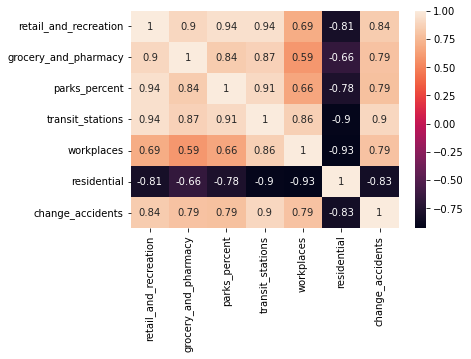

In [82]:
## Merge change in car accidents
google_mobility = google_mobility.merge(daily_accidents_agg[['folio_date', 'change_accidents']],
                                        how='inner',
                                        on='folio_date')

## Estimate correlation matrix
mob_corr = google_mobility.corr()

sns.heatmap(mob_corr, annot=True)
plt.show()

As seen in the last column of the correlation matrix, the percentage change of car accidents has a positive correlation with mobility to public places. And a negative correlation with people being in their houses (residential).

### COVID's quarantine effects on car accidents and crime

In [83]:
## Count the number of days
daily_accidents["dias"] = daily_accidents.index + 1

## Create a cut between the day that COVID's closures started
daily_accidents['dias'] -= int(daily_accidents.loc[daily_accidents['folio_date'] == datetime.datetime(2020, 3, 23),'dias'])

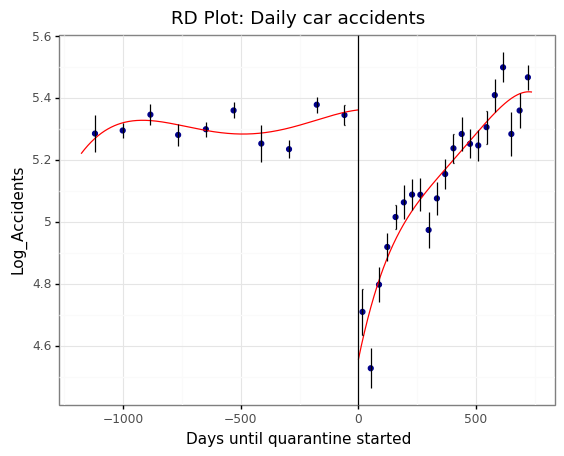


Call: rdplot
Number of Observations:                  1917
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          1178        739
Number of Effective Obs         1178        739
Bandwith poly. fit (h)          1178        738
Number of bins scale               1          1
Bins Selected                     10         21
Average Bin Length             117.8     35.143
Median Bin Length              117.8     35.143
IMSE-optimal bins               10.0       21.0
Mimicking Variance bins         64.0      192.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [84]:
days = daily_accidents["dias"]
accidents = np.log(daily_accidents["accidents"])

## rdplot with 95% confidence intervals
rdplot(y=accidents, x=days, binselect="es", ci=95, 
       title="RD Plot: Daily car accidents", 
       y_label="Log_Accidents",
       x_label="Days until quarantine started")

In [85]:
print(rdrobust(y=accidents, x=days))

Call: rdrobust
Number of Observations:                  1917
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1178        739
Number of Unique Obs.           1178        739
Number of Effective Obs.         140        141
Bandwidth Estimation         140.429    140.429
Bandwidth Bias               294.211    294.211
rho (h/b)                      0.477      0.477

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.654    0.039  -16.867   7.816e-64    [-0.73, -0.578]
Robust                 -        -   -14.97   1.157e-50   [-0.721, -0.554]



In [86]:
## Now we do the same for daily crimes
daily_crimes = matrix_crimes.groupby([matrix_crimes['Hora'].dt.date]).size().reset_index()

## Rename columns
daily_crimes.columns = ['Hora', "crimes"]

daily_crimes["Hora"] = pd.to_datetime(daily_crimes["Hora"])

## Count the number of days
daily_crimes["dias"] = daily_crimes.index + 1

## Create a cut between the day that COVID's closures started
daily_crimes['dias'] -= int(daily_crimes.loc[daily_crimes['Hora'] == datetime.datetime(2020, 3, 23),'dias'])

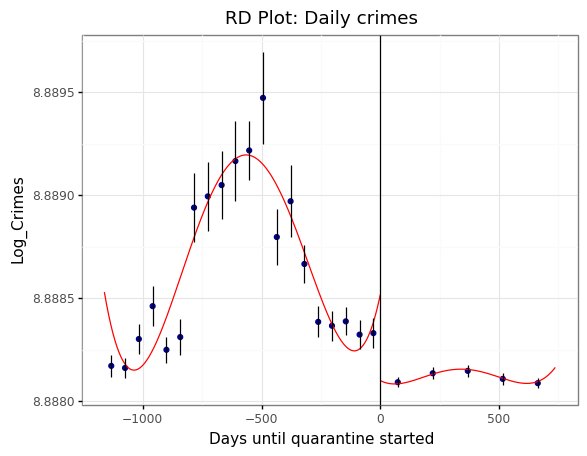


Call: rdplot
Number of Observations:                  1900
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          1162        738
Number of Effective Obs         1161        737
Bandwith poly. fit (h)          1162        737
Number of bins scale               1          1
Bins Selected                     20          5
Average Bin Length              58.1      147.4
Median Bin Length               58.1      147.4
IMSE-optimal bins               20.0        5.0
Mimicking Variance bins         64.0       35.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [87]:
days = daily_crimes["dias"]
crimes = np.log(daily_crimes["crimes"])

## rdplot with 95% confidence intervals
rdplot(y=crimes, x=days, binselect="es", ci=95, kernel='Triangular',
       title="RD Plot: Daily crimes", 
       y_label="Log_Crimes",
       x_label="Days until quarantine started")

In [88]:
print(rdrobust(y=crimes, x=days))

Call: rdrobust
Number of Observations:                  1900
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1162        738
Number of Unique Obs.           1162        738
Number of Effective Obs.         138        139
Bandwidth Estimation         138.499    138.499
Bandwidth Bias               203.431    203.431
rho (h/b)                      0.681      0.681

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        -0.0      0.0   -3.473   5.154e-04       [-0.0, -0.0]
Robust                 -        -    -2.86   4.231e-03       [-0.0, -0.0]



As we can see in the discontinuity regression, Covid's quarantine had some statically significant effects on car accidents in Mexico City. These effects are also graphically visible, where we can see a fall in car accidents that started on March 2021, when the Covid quarantine started. Whatsoever, Covid's quarantine had not a statically significant effect on crimes. Graphically, we can see an increment of crimes between December 2017 and August 2019, but then the registered crimes started to flatten.

In [89]:
## Create a moving avarage
daily_crimes['crimes_rolling'] = daily_crimes['crimes'].rolling(180).mean()

fig = px.line(daily_crimes, x="Hora", y="crimes_rolling")

fig.update_layout(title='Evolution of registered crimes',
                   xaxis_title='Date',
                   yaxis_title='Registered crimes')

fig.show()

### Dummy to control for Covid's quarantine

As we saw in the last cells, there is a correlation between mobility and car accidents, and that Covid's quarantine affected the mobility of the city and hence car accidents. We are interested in a variable that takes into account covid effects and control for predicted crimes during Covid's quarantine. Regardless of whether the quarantine did not affect the crimes, as we saw earlier, because the model can find some signals that can help predict crimes.

So, create a variable that is 0 when the car accidents are within a normal range of variability (pre-Covid quarantine) and is 1 when are below this range.


In [90]:
## Create the dummy and merge with crime matrix
daily_accidents['covid_dummy'] = daily_accidents['change_accidents_ma'].apply(lambda x: 1 if x < lower else 0)

## Create temporal feature to be more easy to merge
matrix_crimes['folio_date'] = pd.to_datetime(matrix_crimes['Hora'].dt.date)

## Merge change in car accidents by date
matrix_crimes = matrix_crimes.merge(daily_accidents[['folio_date', 'change_accidents', 'covid_dummy']],
                                    how='left',
                                    on=['folio_date'])

## Fill Nan values of column "change_accidents" with a -100%.
## Some Alcadias did not report accidents at some dates (specially in the last day of 2018)
matrix_crimes['change_accidents'] = matrix_crimes['change_accidents'].fillna(-100.0)
matrix_crimes['covid_dummy'] = matrix_crimes['covid_dummy'].fillna(0)

In [91]:
del incidentes

matrix_crimes.drop(columns=['folio_date', 'colonia'], axis=1, inplace=True)

In [92]:
del (google_mobility, 
     daily_accidents, 
     incidentes_join, 
     daily_accidents_agg, 
     median_acc_agg, crimes, 
     accidents, daily_crimes)

### Final arrangements

In [93]:
## Merging data from neighborhoods DataFrame (population census, economic units and Subway and bus stations)
matrix_crimes = matrix_crimes.merge(colonias.drop(['colonia','alcaldi','cve_col', 'geometry', 'LinearRing'], axis=1),
                                   how='left',
                                   on='id_colonia')

## Drop additional columns that are not relevant for the model
matrix_crimes = matrix_crimes.drop(['change_accidents', 'christmas', 'christmas_eve', 'last_day_year', 'new_year',
                                    'three_kings', 'day_of_dead', 'independence_day', 'workers_day', 
                                    'constitution_day', 'benito_ann_day', 'revolution_day', 'holy_week'], axis=1)

In [94]:
## Print few observations
matrix_crimes.head()

Hora  id_colonia  day_period  day  month  year Coordinates  \
0 2017-01-16 00:00:00           1           0   16      1  2017        None   
1 2017-01-16 06:00:00           1           1   16      1  2017        None   
2 2017-01-16 12:00:00           1           2   16      1  2017        None   
3 2017-01-16 18:00:00           1           3   16      1  2017        None   
4 2017-01-17 00:00:00           1           0   17      1  2017        None   

   categoria_delito  crimen  dia_semana  indice  past_near_crimes_500mts  \
0               NaN       0           0      61                        0   
1               NaN       0           0      62                        0   
2               NaN       0           0      63                        0   
3               NaN       0           0      64                        0   
4               NaN       0           1      65                        1   

   pay_day  no_labor_day  past_crimes   TEMP  PRCP        CO         O3  \
0        0             0          0.0  59.45   0.0  0.890902  36.186235   
1        0             0          0.0  59.45   0.0  0.890902  36.186235   
2        0             0          0.0  59.45   0.0  0.890902  36.186235   
3        0             0          0.0  59.45   0.0  0.890902  36.186235   
4        0             0          0.0  60.65   0.0  0.760863  35.344061   

        PM10  covid_dummy  area_km2  metro  metrobus  rtp  supers_minisupers  \
0  48.605324            0  3.128549      0         0   38               67.0   
1  48.605324            0  3.128549      0         0   38               67.0   
2  48.605324            0  3.128549      0         0   38               67.0   
3  48.605324            0  3.128549      0         0   38               67.0   
4  45.331019            0  3.128549      0         0   38               67.0   

   department_stores  banks  corporate_offices  restaurants      g_edu  \
0               22.0  186.0               29.0        169.0  13.599699   
1               22.0  186.0               29.0        169.0  13.599699   
2               22.0  186.0               29.0        169.0  13.599699   
3               22.0  186.0               29.0        169.0  13.599699   
4               22.0  186.0               29.0        169.0  13.599699   

   no_healt_s  pop_per_km2  house_per_km2  
0    0.134291  2825.271576      850.23446  
1    0.134291  2825.271576      850.23446  
2    0.134291  2825.271576      850.23446  
3    0.134291  2825.271576      850.23446  
4    0.134291  2825.271576      850.23446

In [95]:
## Memory Usage
def memory_usage(df):
    return(round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))

print('Memory used:', memory_usage(matrix_crimes), 'Mb')

Memory used: 3309.42 Mb


In [96]:
## Memory Usage by column
matrix_crimes.memory_usage(deep=True) / 1024 ** 2

Index                      105.060997
Hora                       105.060997
id_colonia                 105.060997
day_period                  52.530499
day                        105.060997
month                      105.060997
year                       105.060997
Coordinates                105.060997
categoria_delito           105.060997
crimen                      52.530499
dia_semana                 105.060997
indice                     105.060997
past_near_crimes_500mts     52.530499
pay_day                     52.530499
no_labor_day               105.060997
past_crimes                105.060997
TEMP                       105.060997
PRCP                       105.060997
CO                         105.060997
O3                         105.060997
PM10                       105.060997
covid_dummy                105.060997
area_km2                   105.060997
metro                       52.530499
metrobus                    52.530499
rtp                         52.530499
supers_minis

In [97]:
## Info
matrix_crimes.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13770555 entries, 0 to 13770554
Data columns (total 34 columns):
 #   Column                   Non-Null Count     Dtype         
---  ------                   --------------     -----         
 0   Hora                     13770555 non-null  datetime64[ns]
 1   id_colonia               13770555 non-null  int64         
 2   day_period               13770555 non-null  int32         
 3   day                      13770555 non-null  int64         
 4   month                    13770555 non-null  int64         
 5   year                     13770555 non-null  int64         
 6   Coordinates              194150 non-null    geometry      
 7   categoria_delito         194150 non-null    float64       
 8   crimen                   13770555 non-null  int32         
 9   dia_semana               13770555 non-null  int64         
 10  indice                   13770555 non-null  int64         
 11  past_near_crimes_500mts  13770555 non-null  int3

In [98]:
## Save Dataframe into CSV
matrix_crimes.to_csv(create_path(r'base_crimenes.csv'),
                       index=False)